#Import Relevent Python Libraries etc

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os

#Import Outcome Data

In [88]:
#mainpath = 'C:/Users/mb22/OneDrive/PhD/Quasar Shared/' #Files are explicitely specified here and broken into 2 parts 
filepath = 'Data to Import/Prostate Outcome Summary 270515.txt' #so as to be <79 characters
#filepath = 'Data to Import/Prostate Outcome Summary 270515-2.txt'
cwd = os.getcwd()

fullpath=cwd+filepath
print(fullpath)

data = pd.read_table(filepath)
data.rename(columns={data.columns[0]: 'Study'}, inplace=True) # Rename the Study column which is unnamed int he original file

groups = data.groupby('Study')  # assign groups to the studys
data['TCP'] = data['TCP']
data # .head shows the first 5 rows of data, .tail last 5 rows

C:\Users\mb22\OneDrive\PhD\Quasar Shared\Modelling\IPythonData to Import/Prostate Outcome Summary 270515.txt


,Study,Dose,TCP
0,RT01,64,43
1,RT01,74,55
2,MD Anderson,70,43
3,MD Anderson,78,62
4,RMH,64,59
5,RMH,74,71
6,Fox Chase,69,68
7,Fox Chase,71,74
8,Fox Chase,76,69
9,Fox Chase,70,19


#Now plot initial TCP model
****Need to define as a function so can fit.

[  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   6.12006198e-225   2.32973923e-147
   2.19463322e-096   6.81871347e-063   6.91414128e-041   1.98945488e-026
   6.29464630e-017   1.09918804e-010   1.38811161e-006   6.87392726e-004
   4.05323626e-002   5.90428128e-001   3.43204040e+000   1.09091109e+001
   2.33229003e+001   3.84240854e+001   5.33414818e+001   6.61711948e+001
   7.62379345e+001   8.36721464e+001   8.89471492e+001   9.25928313e+001
   9.50691834e+001   9.67322070e+001   9.78406963e+001   9.85759317e+001
   9.90620209e+001   9.93827084e+001   9.95939800e+001   9.97330398e+001
   9.98245142e+001   9.98846629e+001]


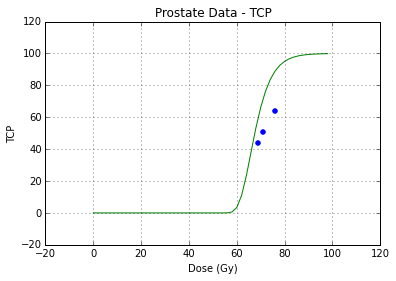

In [8]:
from scipy.optimize import curve_fit

d=2.0 #dose per fraction
N=10**6 #number of tumour cells

D = np.arange(0,100.0,d) #create array containing dose values in increments of d
#print(D)

#n=max(D)/d # total number of fractions in model

a = 0.15 # These are guessed values and can be tweaked manually to give a 'good' fit
abrat = 5
#b = a/abrat

S=np.exp(-a*D*(1+(d/abrat)))
TCP=100*np.exp(-N*S)
print(TCP)

plt.scatter(x=data.Dose, y=data.TCP, color='blue',)
plt.title("Prostate Data - TCP")
plt.xlabel("Dose (Gy)")
plt.ylabel("TCP")
#plt.xlim(0,100)
#plt.ylim(0,100)
plt.grid(True)
plt.plot(D, TCP, color='GREEN')

#Want to now FIT the model to the data
##Least Squares Fitting?

0.372900514911 -0.0012228264304


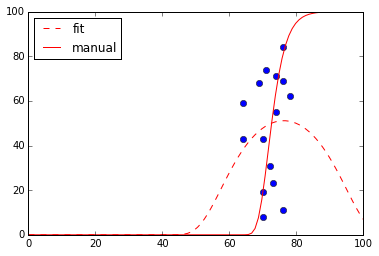

In [89]:
from scipy.optimize import curve_fit

def fit(D, a_fit, b_fit):                      #define TCP function to fit
    s = N*np.exp(-a_fit*D - b_fit*d*D**2)
    TCP = 100*np.exp(-s)
    return TCP

d=2.0 #dose per fraction
N=10**6 #number of tumour cells

x = data.Dose
y = data.TCP

p0 = [0.05,0.001] # intial estimates of fit parameters

xman = np.linspace(0.0, 100.0, 100.0)              # for plotting manually calculated function with initial values
yman = fit(xman, p0[0], p0[1])                # basic fitting function. Doesnt work too well as cant constrain

coeffs, matcov = curve_fit(fit, x, y, p0)      # fit curve against x and y data sets

xfit = np.linspace(0.0, 100.0, 100.0)         # give finer resultion array for plot
yfit = fit(xfit, *coeffs)                    # calculate fitted data with fine array

plt.plot(x, y, 'o')
plt.plot(xfit, yfit, 'r--', label='fit')                  # plot calculated and maual fits
plt.plot(xman, yman, 'r-', label='manual')                       # dashed line is auto fit, solid is manual fit.... these should be the same!!!
plt.legend(loc='best')
print(*coeffs)

In [10]:
data.groupby('Study').count()

,Dose,TCP
Study,,
Fox Chase,3,3


In [11]:
#for i, group in data.groupby('Study'):
#    group.plot(x='Dose', y='TCP', title=str(i))

#plt.scatter(x=data.Dose, y=data.TCP, color='blue',)
#plt.title("Prostate Data - TCP")
#plt.xlabel("Dose (Gy)")
#plt.ylabel("TCP (%)")
#plt.xlim(0,100)
#plt.ylim(0,1)
#plt.grid(True)
#plt.plot(D, TCP, color='red')

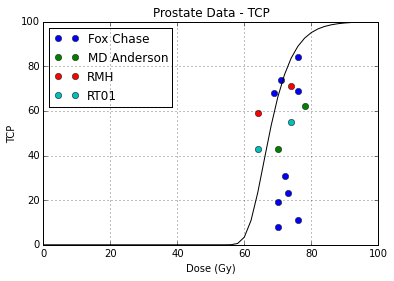

In [90]:
fig, ax = plt.subplots(1,1);
data.groupby('Study').plot(x='Dose', y='TCP', ax=ax, style='o')
plt.legend([data[0] for data in data.groupby('Study')['Study']], loc='best')

plt.title("Prostate Data - TCP")
plt.xlabel("Dose (Gy)")
plt.ylabel("TCP")
plt.xlim(0,100)
plt.ylim(0,100)
plt.grid(True)

plt.plot(D, TCP, color='black')
#plt.plot(xfine, TCP_fit(xfine, *popt), 'r-')

#Use SciPy Optimise to contrain fitting values

In [91]:
from scipy.optimize import leastsq

def fit(D, a_fit, b_fit):                      #define TCP function to fit
    s = N*np.exp(-a_fit*D - b_fit*d*D**2)
    TCP = 100*np.exp(-s)
    return TCP

def func(params, xdata, ydata):
    return (ydata - numpy.dot(xdata, parmas))

xdata = np.transpose(np.array([[1.0]]))

d=2.0 #dose per fraction
N=10**6 #number of tumour cells

x = data.Dose
y = data.TCP

p0 = [0.05,0.001] # intial estimates of fit parameters

xman = np.linspace(0.0, 100.0, 100.0)              # for plotting manually calculated function with initial values
yman = fit(xman, p0[0], p0[1])                # basic fitting function. Doesnt work too well as cant constrain

coeffs, matcov = leastsq(fit, x, y, p0)      # fit curve against x and y data sets

xfit = np.linspace(0.0, 100.0, 100.0)         # give finer resultion array for plot
yfit = fit(xfit, *coeffs)                    # calculate fitted data with fine array

plt.plot(x, y, 'o')
plt.plot(xfit, yfit, 'r--', label='fit')                  # plot calculated and maual fits
plt.plot(xman, yman, 'r-', label='manual')                       # dashed line is auto fit, solid is manual fit.... these should be the same!!!
plt.legend(loc='best')
print(*coeffs)

TypeError: fit() missing 1 required positional argument: 'b_fit'

 linear fit  [  0.87871287 -15.09158416]
TCP fit [ 0.37290051 -0.00122283]


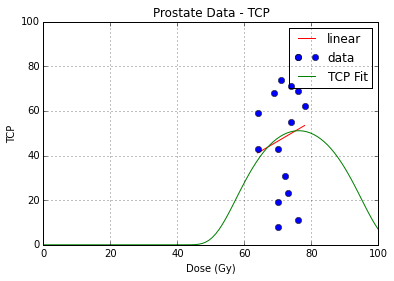

[64 74 70 78 64 74 69 71 76 70 72 76 70 73 76]
[43 55 43 62 59 71 68 74 69 19 31 84  8 23 11]


In [100]:
   # data provided
    

x = np.array(data.Dose)
y = np.array(data.TCP)
    
#x=np.array([1.0,2.5,3.5,4.0,1.1,1.8,2.2,3.7])
#   y=np.array([6.008,15.722,27.130,33.772,5.257,9.549,11.098,28.828])
   # here, create lambda functions for Line, Quadratic fit
   # tpl is a tuple that contains the parameters of the fit
#   funcLine=lambda tpl,x : tpl[0]*x+tpl[1]
    
def funcLine(tpl,x):
    return tpl[0]*x+tpl[1]
   funcQuad=lambda tpl,x : tpl[0]*x**2+tpl[1]*x+tpl[2]

#tpl0 = a_fit    
#tpl1 = b_fit   

def funcTCP(tpl, D):                      #define TCP function to fit
    s = N*np.exp(-tpl[0]*D - tpl[1]*d*D**2)
    TCP = 100*np.exp(-s)
    return TCP


# func is going to be a placeholder for funcLine,funcQuad or whatever 
# function we would like to fit
func=funcLine
# ErrorFunc is the diference between the func and the y "experimental" data
ErrorFunc=lambda tpl,x,y: func(tpl,x)-y
#tplInitial contains the "first guess" of the parameters 
tplInitial1=(1.0,2.0)
# leastsq finds the set of parameters in the tuple tpl that minimizes
# ErrorFunc=yfit-yExperimental
tplFinal1,success=leastsq(ErrorFunc,tplInitial1[:],args=(x,y))
print (" linear fit ", tplFinal1)
xx1=np.linspace(x.min(),x.max(),50)
yy1=func(tplFinal1,xx1)
#------------------------------------------------
# now the TCP fit
#-------------------------------------------------
func=funcTCP
tplInitial2=(0.05,0.001)

tplFinal2,success=leastsq(ErrorFunc,tplInitial2[:],args=(x,y))
print ("TCP fit" ,tplFinal2)
xx2=xx1
xx2=np.linspace(0.0, 100.0, 100.0)

yy2=func(tplFinal2,xx2)

#xfit = np.linspace(0.0, 100.0, 100.0)         # give finer resultion array for plot
#yfit = fit(xfit, *coeffs)                    # calculate fitted data with fine array

#plt.plot(x, y, 'o')
#plt.plot(xfit, yfit, 'r--', label='fit')                  # plot calculated and maual fits

plt.plot(xx1,yy1,'r-', label='linear')
plt.plot(x,y, 'bo', label = 'data')
plt.plot(xx2,yy2,'g-', label = 'TCP Fit')
plt.title("Prostate Data - TCP")
plt.xlabel("Dose (Gy)")
plt.ylabel("TCP")
plt.xlim(0,100)
plt.ylim(0,100)
plt.grid(True)
plt.legend()
plt.show()
print(np.array(data.Dose))
print(np.array(data.TCP))

[64 74 70 78 64 74 69 71 76 70 72 76 70 73 76]
[43 55 43 62 59 71 68 74 69 19 31 84  8 23 11]
x0 = 1.0
y0 = 1.0
c = 1.0
k = 1.0



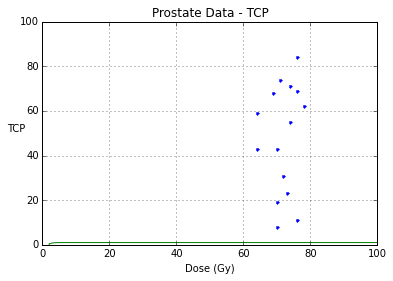

In [99]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

def sigmoid(p,x):
    x0,y0,c,k=p
    y = c / (1 - np.exp(+k*(x-x0))) + y0
    return y

def funcTCP(tpl, D):                      #define TCP function to fit
    s = N*np.exp(-tpl[0]*D - tpl[1]*d*D**2)
    TCP = 100*np.exp(-s)
    return TCP

def residuals(p,x,y):
    return y - sigmoid(p,x)

def resize(arr,lower=0.0,upper=1.0):
    arr=arr.copy()
    if lower>upper: lower,upper=upper,lower
    arr -= arr.min()
    arr *= (upper-lower)/arr.max()
    arr += lower
    return arr

# raw data
#x = np.array([821,576,473,377,326],dtype='float')
#y = np.array([255,235,208,166,157],dtype='float')
x = np.array(data.Dose)
y = np.array(data.TCP)

#x=resize(-x,lower=0.3)
#y=resize(y,lower=0.3)
print(x)
print(y)
p_guess=(1,1,1.0,1.0)
p, cov, infodict, mesg, ier = scipy.optimize.leastsq(
    residuals,p_guess,args=(x,y),full_output=1)  

x0,y0,c,k=p
print('''\
x0 = {x0}
y0 = {y0}
c = {c}
k = {k}
'''.format(x0=x0,y0=y0,c=c,k=k))

xp = np.linspace(0.0, 100.0, 100.0)
pxp=sigmoid(p,xp)

# Plot the results
plt.plot(x, y, '.', xp, pxp, '-')
plt.xlabel('x')
plt.ylabel('y',rotation='horizontal') 
plt.grid(True)
plt.title("Prostate Data - TCP")
plt.xlabel("Dose (Gy)")
plt.ylabel("TCP")
plt.xlim(0,100)
plt.ylim(0,100)
plt.show()